In [2]:
from get_archived_data import prepare_gridded_radar_data_from_zip, npy_to_netcdf, get_cpc_quality_code
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# for a single timestep for any product
timestamp = "20210628155500"
product = "HZT" #Freezing level

level_0deg = prepare_gridded_radar_data_from_zip(product=product, timestamp=timestamp)
level_0deg

array([[  12.5,   12.5,   12.5, ...,   12.5,   12.5,   12.5],
       [3037.5, 3037.5, 3037.5, ..., 3887.5, 3887.5, 3887.5],
       [3037.5, 3037.5, 3037.5, ..., 3887.5, 3887.5, 3887.5],
       ...,
       [3512.5, 3537.5, 3537.5, ..., 4262.5, 4262.5, 4262.5],
       [3537.5, 3537.5, 3537.5, ..., 4262.5, 4262.5, 4262.5],
       [3537.5, 3537.5, 3537.5, ..., 4262.5, 4262.5, 4262.5]],
      dtype=float32)

In [4]:
#get an approximate height of the -20deg line assuming a standard atmosphere (lapse rate of 6.5K/km) https://en.wikipedia.org/wiki/International_Standard_Atmosphere
delta_height = 20 / 6.5 * 1000  #20K / (6.5 K/km) *1000 m/km =
approx_m20deg = level_0deg+delta_height

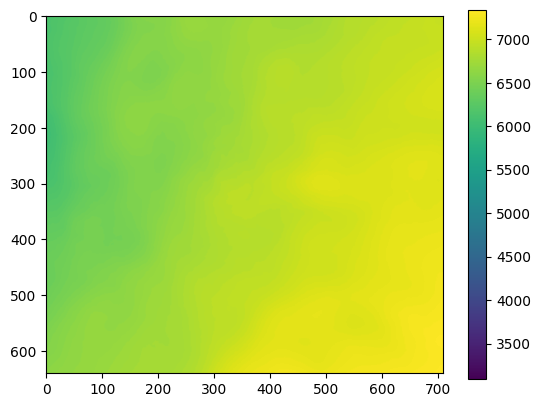

In [5]:
# plt.imshow(level_0deg)
plt.imshow(approx_m20deg)
plt.colorbar()

OZC_h1
OZC_h2
OZC_h3
OZC_h4
OZC_h5
OZC_h6
OZC_h7
OZC_h8
OZC_h9
OZC_h10
OZC_h11
OZC_h12


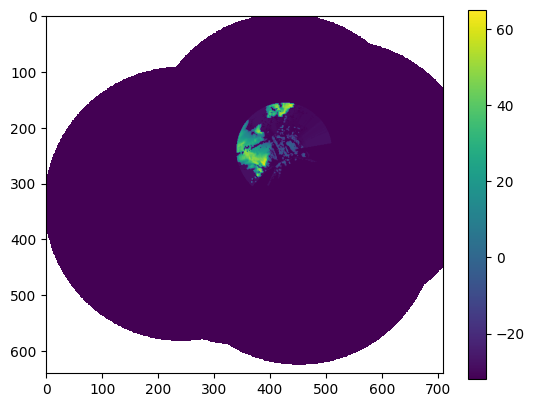

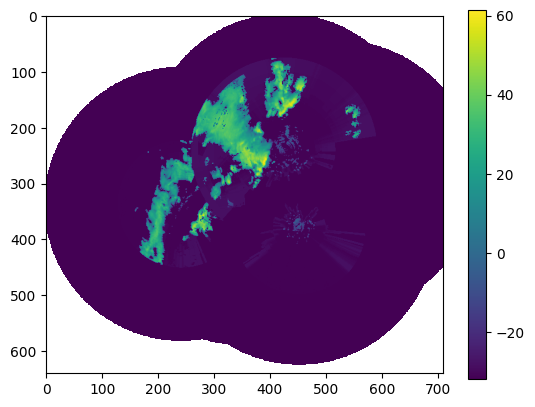

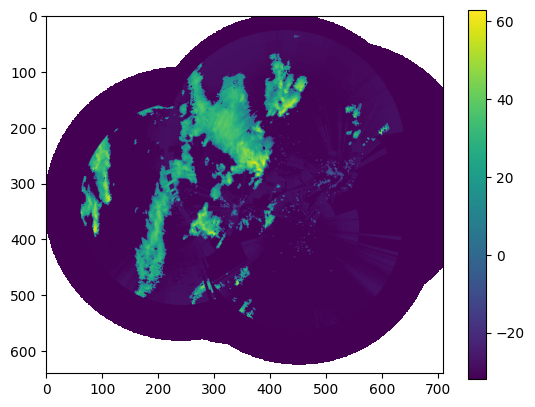

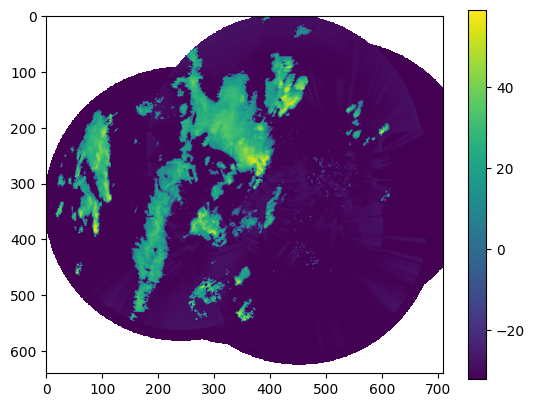

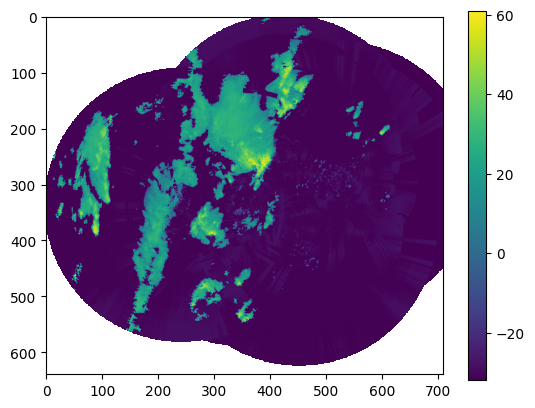

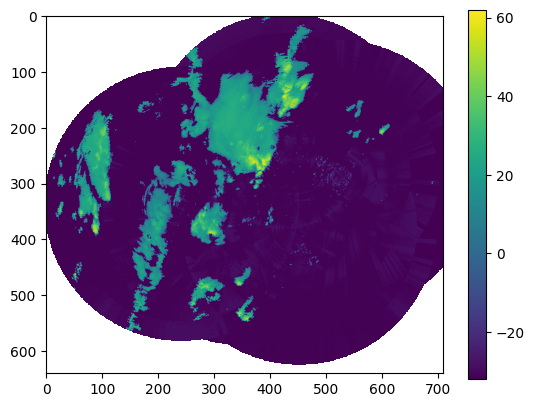

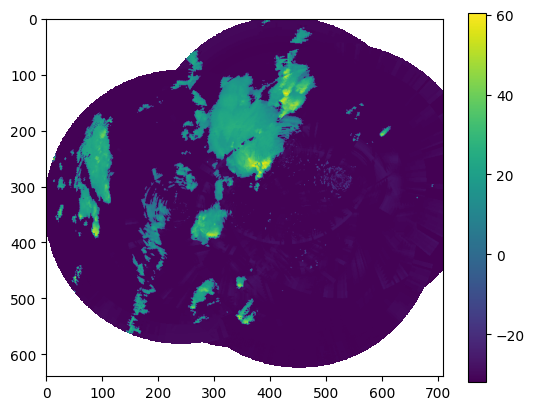

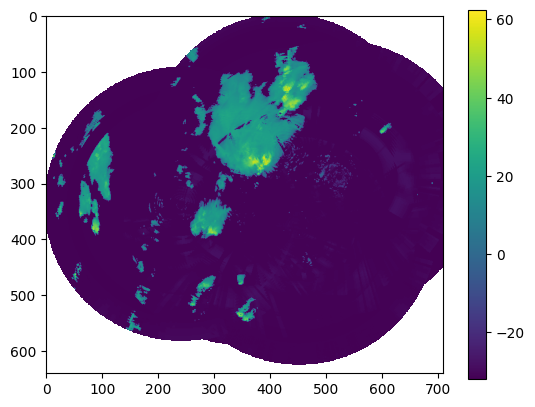

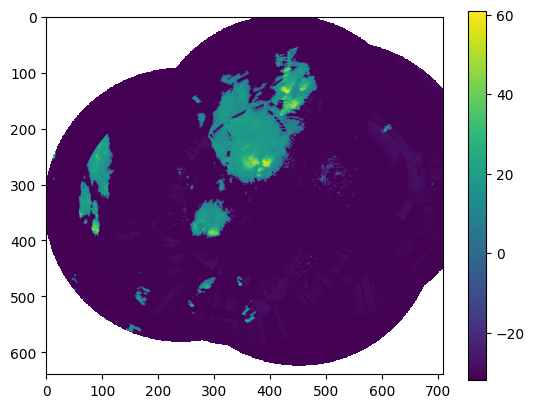

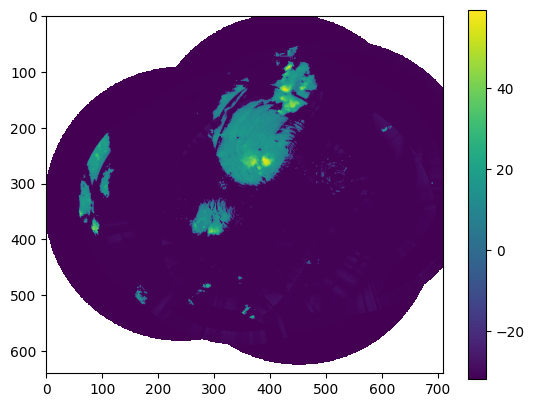

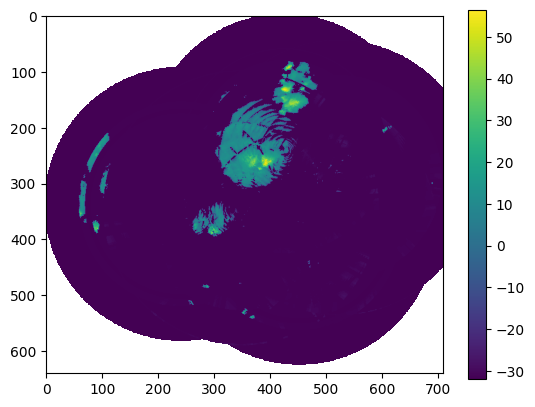

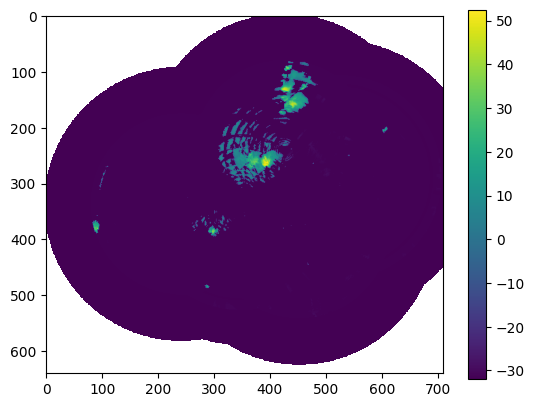

In [6]:
#get Reflectivity CAPPI from heights 1km to 12km (above it get's worse in quality and thunderstorms rarely reach these heights)
height_levels = np.arange(1,12+1)
dBZ_3d = np.empty(shape=(len(height_levels),level_0deg.shape[0],level_0deg.shape[1]))
for i,height in enumerate(height_levels):
    print(f"OZC_h{height}")
    grid = prepare_gridded_radar_data_from_zip(product=f"OZC_h{height}", timestamp=timestamp)
    dBZ_3d[i,:,:] = grid
    plt.figure()
    plt.imshow(grid)
    plt.colorbar()

## SHI calculation

In [7]:
#function definition
# IS SLOWER
# def W(Z,Z_L=40,Z_U=50):
#     if Z<=Z_L:
#         return 0
#     elif Z<Z_U:
#         return (Z-Z_L)/(Z_U-Z_L)
#     else:
#         return 1
# def Ekin(Z):
#     return 5e-6*10**(0.084*Z)*W(Z)
# Ekin = np.vectorize(Ekin)

def W_vec(Z, Z_L=40, Z_U=50):
    return np.where(Z <= Z_L, 0,
                    np.where(Z < Z_U, (Z - Z_L) / (Z_U - Z_L), 1))
def Ekin_vectorize(Z:np.ndarray):
    # return 5e-6 * 10**(0.084*Z)*W(Z) #np.exp(10,0.084*Z)
    power = np.multiply(5e-6 , np.power(10,np.multiply(0.084,Z)))
    weight = W_vec(Z)
    return np.multiply(power, weight)



def W_T_vec(h,h0,hm20):

    if h<=h0:
        out = 0
    elif h<hm20:
        out= (h-h0)/(hm20-h0)
    else:
        out= 1
    return float(out)

W_T_vec = np.vectorize(W_T_vec)

def W_T_vectorize(h, h0, hm20):
    out = np.zeros_like(h0,dtype=float)
    # mask1 = h <= h0
    mask2 = np.logical_and(h > h0, h < hm20)
    mask3 = h >= hm20
    out[mask2] = ((h - h0[mask2]) / (hm20[mask2] - h0[mask2]))
    out[mask3] = 1
    return out

def get_dH_first_lvl_vec(height_first_lvl_arr, height_2nd_lvl_arr, h0):
    if height_first_lvl_arr.shape != height_2nd_lvl_arr.shape:
        raise ValueError("Input arrays must have the same shape")

    dH_arr = np.where(height_first_lvl_arr > h0, (height_first_lvl_arr + height_2nd_lvl_arr) / 2 - h0,
                      height_2nd_lvl_arr - height_first_lvl_arr)
    return dH_arr


def SHI(h_arr,Z_arr,h0_2d,hm20_2d): # with 2d h0,hm20 arrays
    np.testing.assert_array_equal(h_arr,np.sort(h_arr))

    shi=0
    for level in range(len(h_arr)):
        # if h_arr[level]<h0:
        #     continue
        if level==0:
            dH = get_dH_first_lvl_vec(h_arr[level],h_arr[level+1],h0_2d)
            # dH = h_arr[level+1]-h_arr[level]
        elif level == len(h_arr)-1:
            dH = h_arr[level]-h_arr[level-1]
        else:
            dH = (h_arr[level+1]-h_arr[level-1])/2

        # add_shi = W_T_vec(h_arr[level],h0=h0_2d,hm20=hm20_2d)*Ekin(Z_arr[level])*dH
        weight = W_T_vectorize(h_arr[level],h0=h0_2d,hm20=hm20_2d)
        # Ekin_here = Ekin(Z_arr[level])
        Ekin_here = Ekin_vectorize(Z_arr[level])
        # np.testing.assert_array_almost_equal(Ekin_here,Ekin2,decimal=5)
        add_shi = weight*Ekin_here*dH
        # add_shi = W_T_vectorize(h_arr[level],h0=h0_2d,hm20=hm20_2d)*Ekin(Z_arr[level])*dH
        # np.testing.assert_array_almost_equal(add_shi,add_shi2,decimal=5) #is oke
        if np.isnan(add_shi).sum()>0:
            raise ValueError("nan values in shi part")
        shi += add_shi

    shi = 0.1*shi
    return shi



In [10]:
def get_SHI(timestamp,height_levels=None):

    #"HZT" =  #Freezing level
    level_0deg = prepare_gridded_radar_data_from_zip(product="HZT", timestamp=timestamp)

    #get an approximate height of the -20deg line assuming a standard atmosphere (lapse rate of 6.5K/km) https://en.wikipedia.org/wiki/International_Standard_Atmosphere
    delta_height = 20 / 6.5 * 1000  #20K / (6.5 K/km) *1000 m/km =
    approx_m20deg = level_0deg+delta_height

    # Define default height levels (1 to 12 km)  (above it get's worse in quality and thunderstorms rarely reach these heights)
    if height_levels is None:
        height_levels = np.arange(1,12+1)

    #get Reflectivity CAPPI from all selected heights
    dBZ_3d = np.empty(shape=(len(height_levels),level_0deg.shape[0],level_0deg.shape[1]))
    for i,height in enumerate(height_levels):
        grid = prepare_gridded_radar_data_from_zip(product=f"OZC_h{height}", timestamp=timestamp)
        dBZ_3d[i,:,:] = grid

    shi = SHI(height_levels*1e3,np.nan_to_num(dBZ_3d),h0_2d=level_0deg,hm20_2d=approx_m20deg)
    return shi


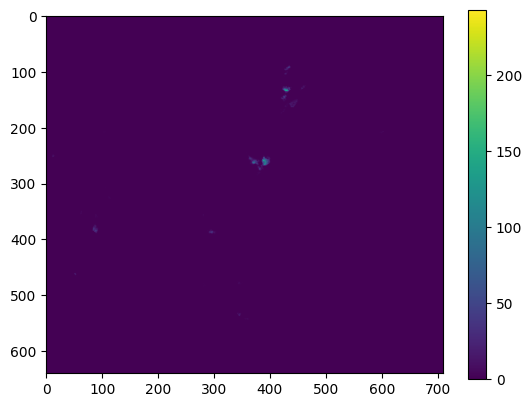

In [11]:
shi1 = get_SHI(timestamp)
plt.imshow(shi1)
plt.colorbar()

In [14]:
shi = SHI(height_levels*1e3,np.nan_to_num(dBZ_3d),h0_2d=level_0deg,hm20_2d=approx_m20deg)
np.testing.assert_array_equal(shi,shi1)

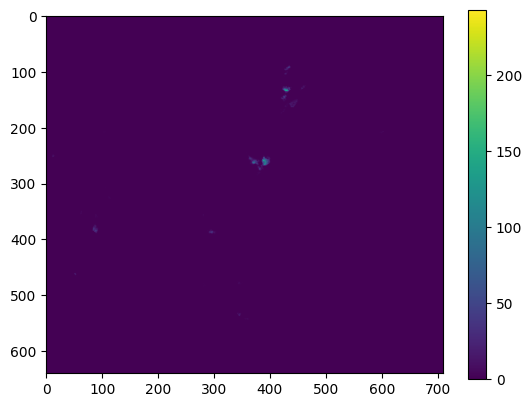

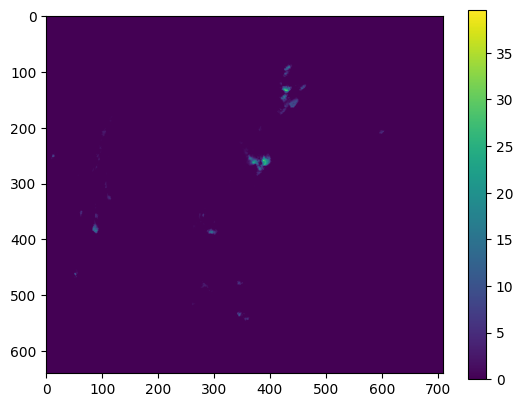

In [99]:
plt.imshow(shi)
plt.colorbar()
plt.figure()
plt.imshow(2.54*(shi)**0.5)
plt.colorbar()

In [86]:
%%timeit
np.nan_to_num(dBZ_3d)[:,:,:]*5e-6

99.5 ms ± 3.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
# !pip install line_profiler
%load_ext line_profiler
%lprun -f SHI -f Ekin_vectorize -f W_T_vectorize SHI(height_levels*1e3,np.nan_to_num(dBZ_3d)[:,:,:],h0_2d=level_0deg,hm20_2d=approx_m20deg)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 0.279737 s
File: /tmp/ipykernel_15153/71921550.py
Function: Ekin_vectorize at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def Ekin_vectorize(Z:np.ndarray):
    20                                               # return 5e-6 * 10**(0.084*Z)*W(Z) #np.exp(10,0.084*Z)
    21        12  246100307.0    2e+07     88.0      power = np.multiply(5e-6 , np.power(10,np.multiply(0.084,Z)))
    22        12   26172291.0    2e+06      9.4      weight = W_vec(Z)
    23        12    7463995.0 621999.6      2.7      return np.multiply(power, weight)

Total time: 0.0262109 s
File: /tmp/ipykernel_15153/71921550.py
Function: W_T_vectorize at line 39

Line #      Hits         Time  Per Hit   % Time  Line Contents
    39                                           def W_T_vectorize(h, h0, hm20):
    40        12    3705885.0 308823.8     14.1      out = np.zeros_like(h0,dtype=float)
    41        12    